In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gp
from sklearn.preprocessing import normalize
from scipy.sparse import coo_matrix, csr_matrix


%matplotlib inline

In [611]:
tops=pd.read_csv(r'D:\prbtops.csv')
small=tops.head()

In [612]:
tops.head()

,api,formation,depth,ssdepth
0,105177.0,FRONTIER,1180.0,error-No Elev. data
1,105177.0,MUDDY,1904.0,error-No Elev. data
2,105177.0,DAKOTA,2040.0,error-No Elev. data
3,105177.0,LAKOTA,2080.0,error-No Elev. data
4,105177.0,MORRISON,2120.0,error-No Elev. data


In [563]:
data=np.asarray(tops[['api', 'formation', 'depth']])

In [390]:
n_wells = tops.api.unique().shape[0]
n_formations = tops.formation.unique().shape[0]

print('Number of wells: {}'.format(n_wells))
print('Number of formations: {}'.format(n_formations))
print('Sparsity: {:4.3f}%'.format(float(tops.shape[0]) / float(n_wells*n_formations) * 100))

Number of wells: 2861
Number of formations: 442
Sparsity: 1.180%


In [391]:
formation_to_idx = {}
idx_to_formation = {}
for (idx, formation) in enumerate(tops.formation.unique().tolist()):
    formation_to_idx[formation] = idx
    idx_to_formation[idx] = formation
    
api_to_idx = {}
idx_to_api = {}
for (idx, api) in enumerate(tops.api.unique().tolist()):
    api_to_idx[api] = idx
    idx_to_api[idx] = api

In [392]:
def map_ids(row, mapper):
    return mapper[row]
import scipy.sparse as sparse


In [580]:
#%%timeit
I = tops.api.apply(map_ids, args=[api_to_idx]).as_matrix()
J = tops.formation.apply(map_ids, args=[formation_to_idx]).as_matrix()
V = tops.depth.astype(int)
likes = sparse.coo_matrix((V, (I, J)), dtype=np.float64)
likes = likes.tocsr()

In [394]:
print('Number of data points: {}'.format(n_wells*n_formations))

Number of data points: 1264562


In [12]:
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
U, sigma, Vt = svds(likes, k=100)

In [443]:
well_factors, _, formation_factors=svds(likes,5)

In [413]:
formation_factors.shape


(20, 442)

In [444]:
squirrel=[]
from scipy import spatial

for i in range(441):
    squirrel.append(1-spatial.distance.cosine(formation_factors[:,1],formation_factors[:,i]))

In [445]:
tops.formation.unique()[np.where(np.asarray(squirrel)>0.98)]


array(['LANCE', 'BOIS MARKER', 'LANCE YELLOW POINT', 'SURFACE',
       'LANCE B COAL', 'LANCE MIDDLE COAL', 'UPPER LANCE B', 'T UNNAMED',
       'JONAH - 1ST', 'JONAH SANDSTONE', 'WARDELL/LANCE', 'JONAH/ LANCE'],
      dtype=object)

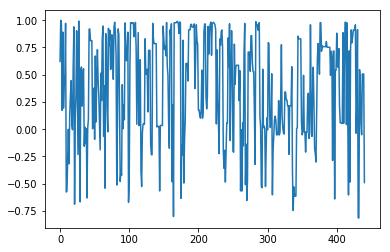

In [446]:
plt.plot(squirrel)

In [447]:
sigma = np.diag(_)

In [495]:
ewe=well_factors
eye=np.dot(sigma, formation_factors)
rui=np.dot(well_factors, np.dot(sigma, formation_factors))
eye.shape

(5, 442)

In [463]:
def SGD(data):
    '''Learn the vectors p_u and q_i with SGD.
       data is a dataset containing all ratings + some useful info (e.g. number
       of items/users).
    '''

    n_factors = 5  # number of factors
    alpha = .01  # learning rate
    n_epochs = 10  # number of iteration of the SGD procedure

    # Randomly initialize the user and item factors.
    p = np.random.normal(0, .1, (data.shape[0], n_factors))
    q = np.random.normal(0, .1, (data.shape[1], n_factors))

    # Optimization procedure
    for _ in range(n_epochs):
        for u, i, r_ui in data:
            err = r_ui - np.dot(p[u], q[i])
            # Update vectors p_u and q_i
            p[u] += alpha * err * q[i]
            q[i] += alpha * err * p[u]

In [464]:
def estimate(u, i):
    '''Estimate rating of user u for item i.'''
    return np.dot(p[u], q[i])

In [564]:
n_factors = 5  # number of factors
alpha = .01  # learning rate
n_epochs = 10  # number of iteration of the SGD procedure

    # Randomly initialize the user and item factors.
p = np.random.normal(0, .1, (n_wells, n_factors))
q = np.random.normal(0, .1, (n_formations, n_factors))

for u, i, r_ui in data:
    err = np.dot(p[u], q[i])
    # Update vectors p_u and q_i
    p[u] += alpha * err * q[i]
    q[i] += alpha * err * p[u]

IndexError: index 3521913 is out of bounds for axis 0 with size 2861

In [631]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import SVD


# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': [1, 1, 1, 2, 2],
                'userID': [9, 32, 2, 45, 'user_foo'],
                'rating': [3, 2, 4, 3, 1]}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 20000))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(tops[['api', 'formation', 'depth']], reader)
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)
data

RMSE: nan


In [638]:
predictions

[Prediction(uid=537477.0, iid='SMITH', r_ui=608.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=522220.0, iid='MUDDY-FM', r_ui=8440.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=537600.0, iid='ANDERSON', r_ui=328.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=532368.0, iid='WYODAK COAL', r_ui=871.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=529722.0, iid='FOX HILLS', r_ui=4194.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=551436.0, iid='BIG GEORGE BOTTOM', r_ui=1174.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=546271.0, iid='BIG GEORGE', r_ui=1106.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=922935.0, iid='FOX HILLS', r_ui=7383.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=561593.0, iid='SHANNON', r_ui=10257.0, est=20000, details={'was_impossible': False}),
 Prediction(uid=520857.0, iid='PIERRE-SH', r_ui=4943.0, est=20000, detai

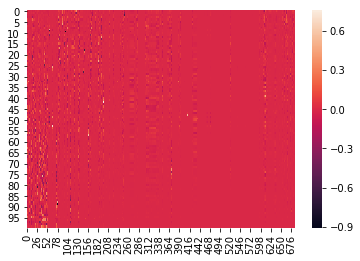

In [204]:
import seaborn as sns

sns.heatmap(Vt)
meandepths=np.mean(likes, axis=1)
likesdemeaned = likes-meandepths.reshape(-1,1)

In [205]:
all_tops= np.dot(np.dot(U, sigma), Vt) + meandepths.reshape(-1,1)

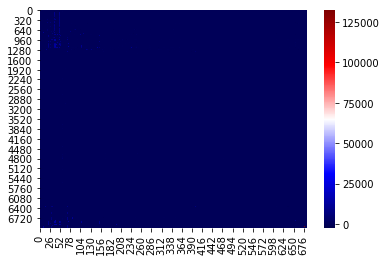

In [206]:
sns.heatmap(all_tops, cmap='seismic')

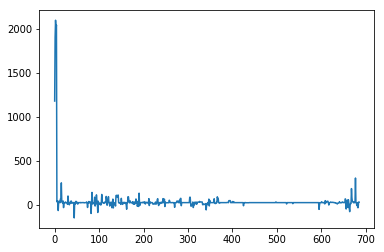

In [207]:
plt.plot(np.ndarray.flatten(np.asarray(all_tops[0])))

In [190]:
tops[tops['api']==105177]

,api,formation,depth,ssdepth
0,105177,FRONTIER,1180.0,error-No Elev. data
1,105177,MUDDY,1904.0,error-No Elev. data
2,105177,DAKOTA,2040.0,error-No Elev. data
3,105177,LAKOTA,2080.0,error-No Elev. data
4,105177,MORRISON,2120.0,error-No Elev. data
5,105177,CHUGWATER,2580.0,error-No Elev. data
6,105177,CASPER-TENSLEEP,3518.0,error-No Elev. data


In [97]:
idx_to_formation

{0: 'WASATCH',
 1: 'LANCE',
 2: 'LANCE - OVER PRESSURE',
 3: 'JONAH',
 4: 'YELLOW POINT',
 5: 'WARDELL',
 6: 'MESAVERDE',
 7: nan,
 8: 'LEWIS',
 9: 'FORT UNION',
 10: 'FORT UNION BASE',
 11: 'LANCE UPPER',
 12: 'LANCE LOWER',
 13: 'ERICSON',
 14: 'FORT UNION TOP',
 15: 'BASE FORT UNION',
 16: 'UPPER LANCE',
 17: 'LOWER LANCE',
 18: 'UPPER MESAVERDE',
 19: 'UPPERMESAVERDE',
 20: 'TOP OF YELLOW POINT',
 21: 'TERTIARY LAKE',
 22: 'MESAVERDE UPPER',
 23: 'TD',
 24: 'FORT UNION LOWER',
 25: 'FORT UNION UPPER',
 26: 'TERTIARY',
 27: 'BIOS MARKER',
 28: 'BOIS MARKER',
 29: 'B ASE FORT UNION',
 30: 'MESVAERDE UPPER',
 31: 'LANCE-UPPER',
 32: 'LANCE-LOWER',
 33: 'LANCE SH',
 34: 'LANCE B',
 35: 'LANCE M',
 36: 'LANCE TOP UPPER',
 37: 'JONAH TOP',
 38: 'YELLOWPOINT TOP',
 39: 'WARDELL TOP',
 40: 'YELLOWPOINT',
 41: 'LANCE UPPER TOP',
 42: 'YELLOW POINT TOP',
 43: 'UNNAMED TERTIARY',
 44: 'BOIS MARK',
 45: 'BASE FT. UNION',
 46: 'LANCE- UPPER',
 47: 'MESAVERDE-UPPER',
 48: 'LANCE TOP OF UPPER',
 

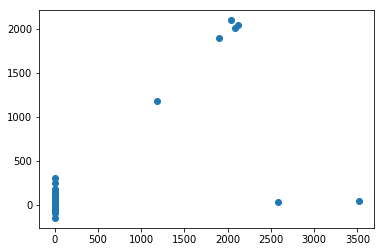

In [208]:
plt.scatter(np.asarray(likes[0].todense()),np.ndarray.flatten(np.asarray(all_tops[0])))

In [187]:
np.asarray(likes[0].todense())

array([[1180., 1904., 2040., 2080., 2120., 2580., 3518.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      